In [ ]:
# 2025
# Figure 2A and Supplementary Figure 3.

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text  # Adjust text to avoid overlapping


In [9]:

# load data to use in analysis

df_npq =  pd.read_excel("Supplementary_Dataset.xlsx", sheet_name="NPQ_and_SIMOA_Data")



In [10]:
# Build mapping dict for Mapping Target Names to be used in paper
df_target_names = pd.read_excel("Supplementary_Dataset.xlsx", sheet_name="Target Name")
mapping = dict(zip(df_target_names["Target Name on NULISAseq™ CNS Disease Panel "], df_target_names["Target Name used in the paper"]))

# Rename columns
data = df_npq.rename(columns=mapping)

In [11]:
# drop markers that were not used in t-test analysis
data = data.drop(columns=["Apo-E4", # Drop APOE4 (binary data) from t-test analysis;
                        "Simoa NfL log2(pg/mL)", "Simoa NfL (pg/mL)", "Simoa GFAP log2(pg/mL)", "Simoa GFAP (pg/mL)", # Drop repeat Simoa Data;
                        "PTN", "GDI-1", "Beta-synuclein"]) # Exclude nulisa markers from analysis which did not meet detectability cut-off;



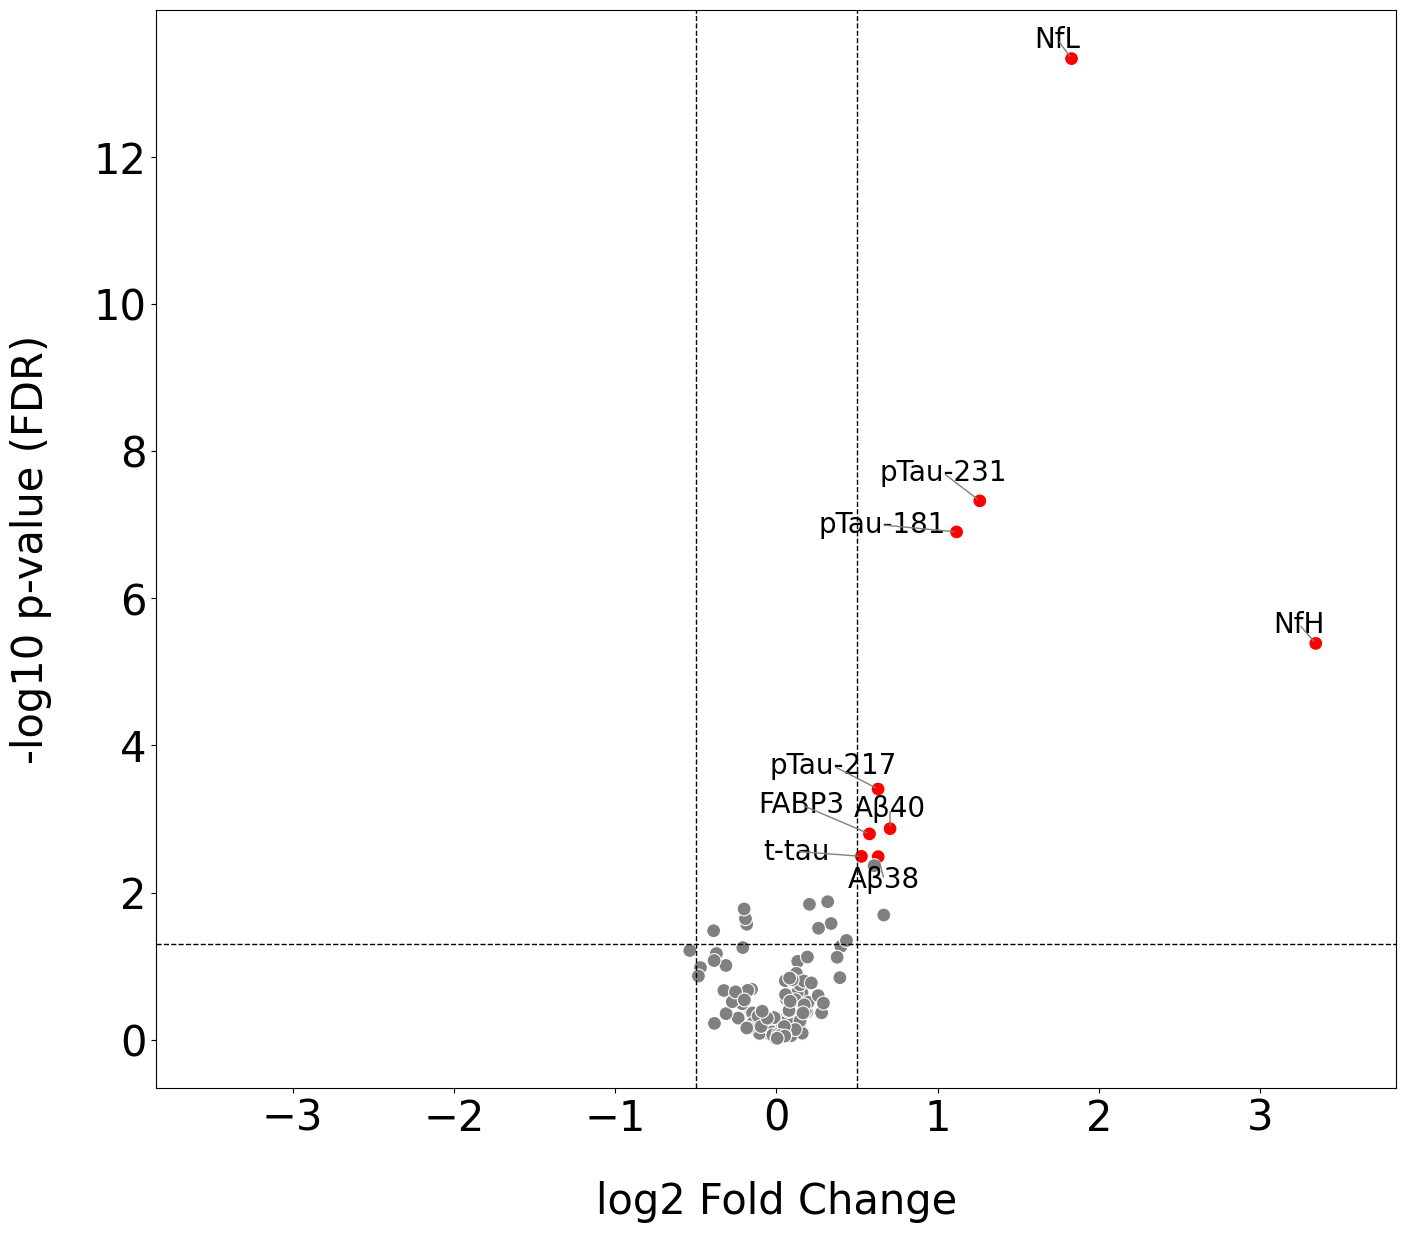

In [16]:
# Conduct statistical analysis - Figure 2A 

# create list for results
log2_fold_changes = []
p_values = []
biomarker_names = []


# Calculate log2 fold change and p-values for each biomarker
for biomarker in data.columns[2:]:  # Exclude the 'Group' column
    control_values = data[data['Group'] == 'Control'][biomarker]
    disease_values = data[data['Group'] == 'MND'][biomarker]
    
    # Calculate log2 fold change (mean difference in log2 scale)
    log2_fc = disease_values.mean() - control_values.mean()
    log2_fold_changes.append(log2_fc)
    
    # Perform t-test to obtain p-value
    _, pval = ttest_ind(disease_values, control_values)
    p_values.append(pval)
    biomarker_names.append(biomarker)

# FDR adjustment for multiple comparisons
_, adj_p_values, _, _ = multipletests(p_values, method= "fdr_bh")

# Create a DataFrame to hold the results
volcano_data = pd.DataFrame({
    'biomarker': data.columns[2:],
    'log2FoldChange': log2_fold_changes,
    'pval': p_values,
    'adj_pval': adj_p_values
})

# Determine color coding based on significance
def get_color(row):
    if row['adj_pval'] < 0.05:
        return 'red'  # Significant after FDR correction
    else:
        return 'gray'  # Not significant

volcano_data['color'] = volcano_data.apply(get_color, axis=1)

# Plotting the volcano plot
plt.figure(figsize=(16, 14)) 

sns.scatterplot(
    data=volcano_data,
    x='log2FoldChange',
    y=-np.log10(volcano_data['pval']),
    hue='color',
    s = 100, 
    palette={'red': 'red', 'gray': 'gray'},
    legend=None
)

# Adding labels and thresholds for clarity
plt.axhline(-np.log10(0.05), color='black', linestyle='--', linewidth=1)
plt.xlabel('log2 Fold Change', fontsize = 30, labelpad=30) 
plt.ylabel('-log10 p-value (FDR)', fontsize = 30, labelpad=30)
plt.xticks(fontsize=30)  # Rotate x-ticks vertically
plt.yticks(fontsize=30)   # Rotate y-ticks vertically


# Add labels for significant biomarkers
texts = []  

p_values = np.array(p_values)
biomarker_names = np.array(biomarker_names)
neg_log10_p_values = -np.log10(p_values)
pval_threshold = 0.05
significant = (adj_p_values < pval_threshold)
for i in range(len(biomarker_names)):
    if significant[i]:
        text = plt.text(log2_fold_changes[i], neg_log10_p_values[i], biomarker_names[i], fontsize=20, ha='right', va='bottom', color='black') 
        texts.append(text)
        
plt.axvline(x=0.5, color='black', linestyle='--', linewidth = 1)
plt.axvline(x=-0.5, color='black', linestyle='--', linewidth = 1)
x_lim = max(np.abs(log2_fold_changes)) +0.5
plt.xlim([-x_lim, x_lim])
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray') ,  expand_points=(0.1, 0.1), force_text=0.6)
plt.savefig(f".\\figures\\volcano_main.png", dpi=300)
plt.show()

# # # Print the results with log2 fold changes, unadjusted and adjusted p-values
# results = volcano_data[['biomarker', 'log2FoldChange', 'pval', 'adj_pval']]
# results.to_csv("statistics_volcano.csv")
# # # Round only float columns to 2 decimals
# float_cols = results.select_dtypes(include="float").columns
# results[float_cols] = results[float_cols].round(2)
# results.to_csv("statistics_volcano_rounded.csv")




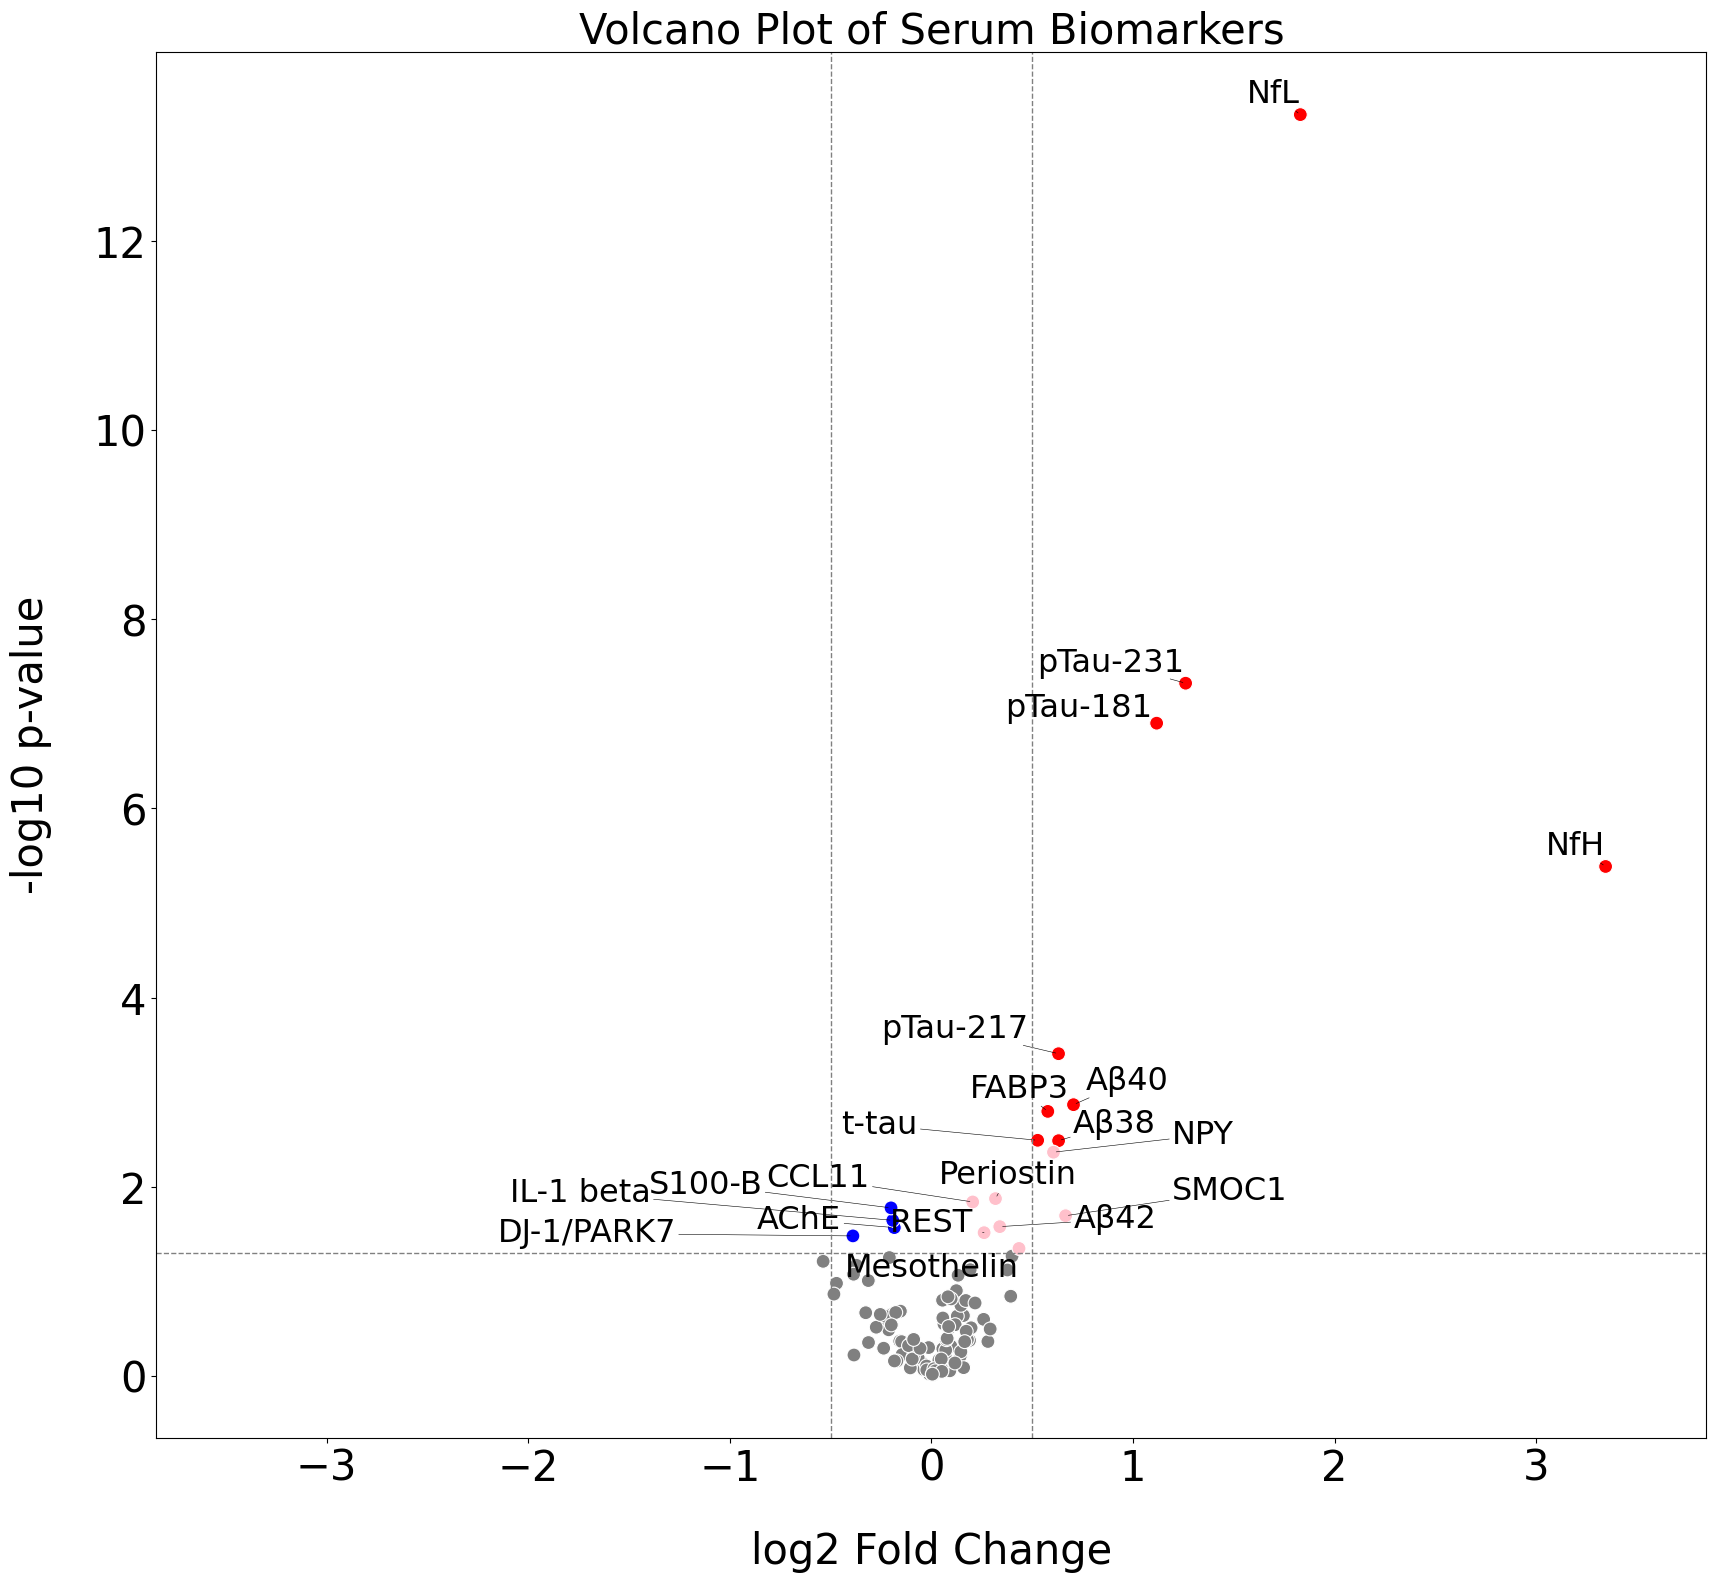

In [13]:
# Conduct statistical analysis - Supplementary Figure 3

# create list for results
log2_fold_changes = []
p_values = []
biomarker_names = []


# Calculate log2 fold change and p-values for each biomarker
for biomarker in data.columns[2:]:  # Exclude the 'Group' column
    control_values = data[data['Group'] == 'Control'][biomarker]
    disease_values = data[data['Group'] == 'MND'][biomarker]
    
    # Calculate log2 fold change (mean difference in log2 scale)
    log2_fc = disease_values.mean() - control_values.mean()
    log2_fold_changes.append(log2_fc)
    
    # Perform t-test to obtain p-value
    _, pval = ttest_ind(disease_values, control_values)
    p_values.append(pval)
    biomarker_names.append(biomarker)

# FDR adjustment for multiple comparisons
_, adj_p_values, _, _ = multipletests(p_values, method= "fdr_bh", alpha= 0.05)

# Create a DataFrame to hold the results
volcano_data = pd.DataFrame({
    'biomarker': data.columns[2:],
    'log2FoldChange': log2_fold_changes,
    'pval': p_values,
    'adj_pval': adj_p_values
})

# Determine color coding based on significance
def get_color(row):
    if row['adj_pval'] < 0.05:
        return 'red'  # Significant after FDR correction
    elif row['pval'] < 0.05 and row['log2FoldChange'] > 0:
        return 'pink'  # Elevated only with unadjusted p-value
    elif row['pval'] < 0.05 and row['log2FoldChange'] < 0:
        return 'blue'  # Lowered only with unadjusted p-value
    else:
        return 'gray'  # Not significant

volcano_data['color'] = volcano_data.apply(get_color, axis=1)

# Plotting the volcano plot
plt.figure(figsize=(20, 18))
sns.scatterplot(
    data=volcano_data,
    x='log2FoldChange',
    y=-np.log10(volcano_data['pval']),
    s = 100,
    hue='color',
    palette={'red': 'red', 'pink': 'pink', 'blue': 'blue', 'gray': 'gray'},
    legend=None
)

# Adding labels and thresholds for clarity
plt.axhline(-np.log10(0.05), color='gray', linestyle='--', linewidth=1)
plt.xlabel('log2 Fold Change', fontsize = 30, labelpad=30)
plt.ylabel('-log10 p-value', fontsize = 30, labelpad=30)
plt.title('Volcano Plot of Serum Biomarkers', fontsize = 30)
plt.xticks(fontsize=30)  # Rotate x-ticks vertically
plt.yticks(fontsize=30)   # Rotate y-ticks vertically

# Add labels for significant biomarkers
texts = [] 

p_values = np.array(p_values)
biomarker_names = np.array(biomarker_names)
neg_log10_p_values = -np.log10(p_values)
pval_threshold = 0.05
significant = (p_values < pval_threshold)

for i in range(len(biomarker_names)):
    if significant[i]:
        text = plt.text(log2_fold_changes[i], neg_log10_p_values[i], biomarker_names[i],fontsize=23, ha='right', va='bottom', color='black')
        texts.append(text)


plt.axvline(x=0.5, color='gray', linestyle='--', linewidth = 1)
plt.axvline(x=-0.5, color='gray', linestyle='--', linewidth = 1)
x_lim = max(np.abs(log2_fold_changes)) +0.5
plt.xlim([-x_lim, x_lim])

adjust_text(
    texts,
    arrowprops=dict(arrowstyle="-", color='black', lw=0.4),
    force_text=0.5,
    force_pull=0.3,
    only_move={'pull': 'y', 'text':'xy'}
)

plt.savefig(f".\\figures\\volcano_supplementary.png", dpi=300)
plt.show()


# # # Print the results with log2 fold changes, unadjusted and adjusted p-values
# results = volcano_data[['biomarker', 'log2FoldChange', 'pval', 'adj_pval']]
# results.to_csv("statistics_volcano_supplementary.csv")
# # # Round only float columns to 2 decimals
# float_cols = results.select_dtypes(include="float").columns
# results[float_cols] = results[float_cols].round(2)
# results.to_csv("statistics_volcano_rounded_supplementary.csv")
